/tmp/ipython-input-1901426959.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  impulse_total = np.trapz(strike_data['Force Resultant,N'], x=strike_data['Time,s'])
/tmp/ipython-input-1901426959.py:53: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  impulse_to_peak = np.trapz(strike_data.loc[:peak_rel_idx, 'Force Resultant,N'],


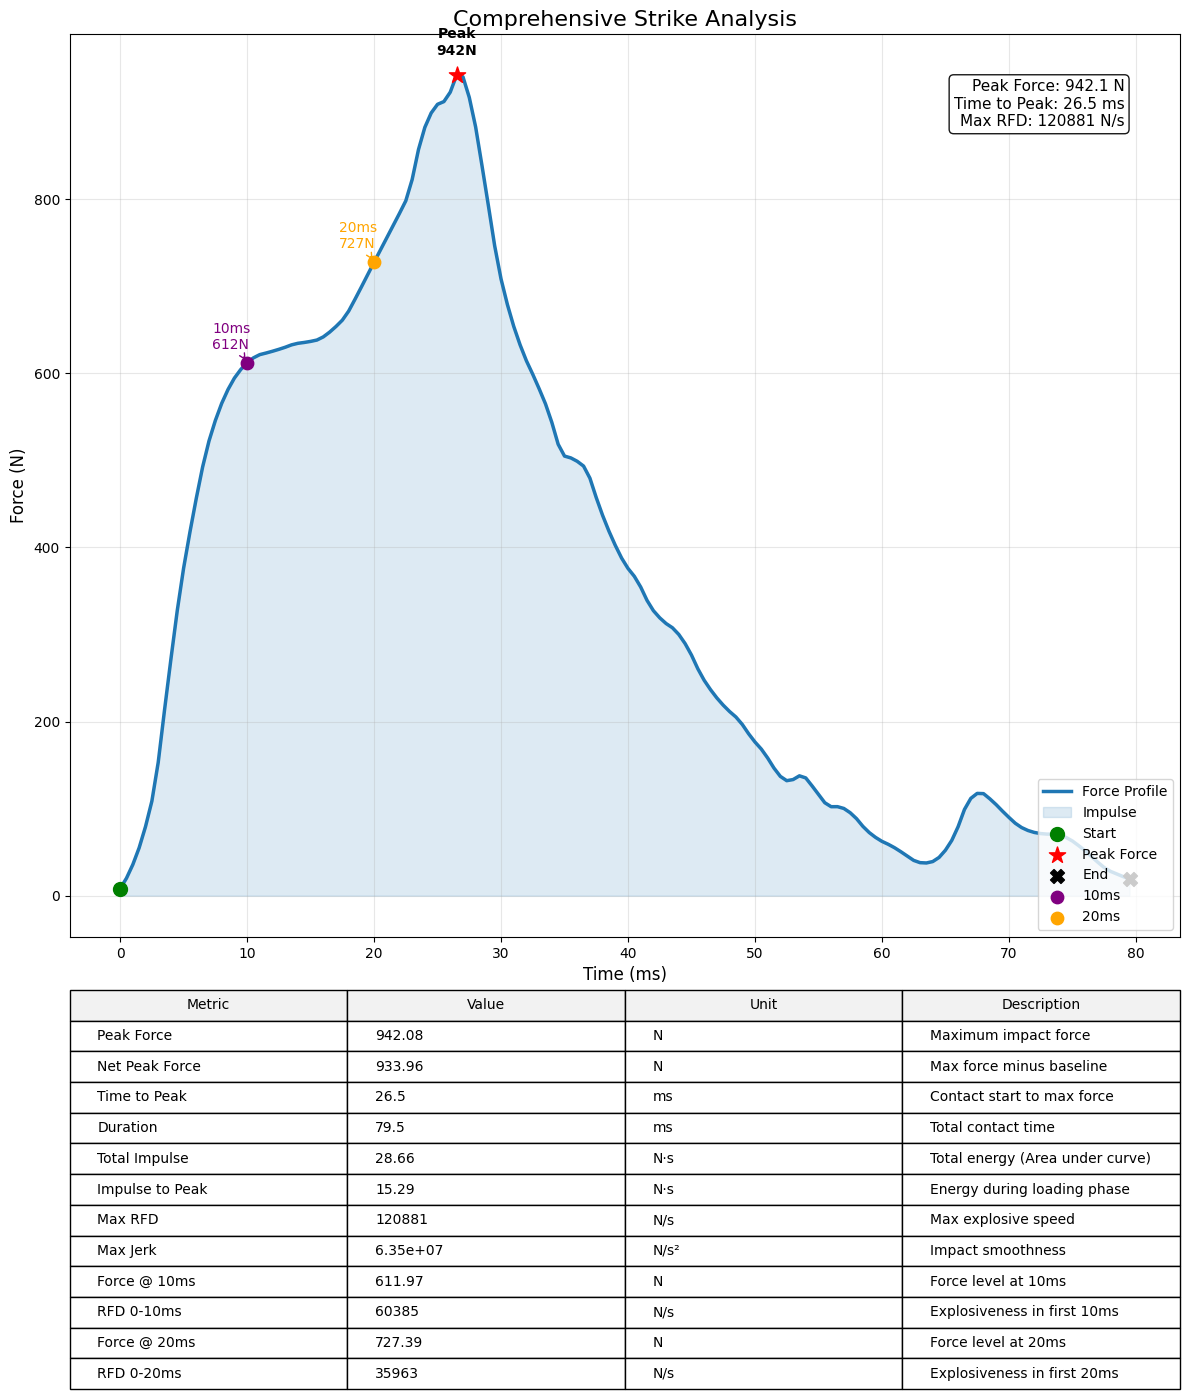

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load and Preprocess Data ---
# Ensure this matches your filename exactly
filename = 'left hand speed big target southpaw.xlsx'
df = pd.read_excel(filename, skiprows=3)

# Calculate Resultant Force
df['Force Resultant,N'] = np.sqrt(
    df['Force plate Fx,N']**2 +
    df['Force plate Fy,N']**2 +
    df['Force plate Fz,N']**2
)

# --- 2. Slicing Algorithm (Find the Biggest Strike) ---
peak_idx = df['Force Resultant,N'].idxmax()
threshold_onset = 20 # N (Noise threshold)

# Find Start (Onset)
onset_idx = peak_idx
for i in range(peak_idx, 0, -1):
    if df.loc[i, 'Force Resultant,N'] < threshold_onset:
        onset_idx = i
        break
time_onset = df.loc[onset_idx, 'Time,s']
force_onset = df.loc[onset_idx, 'Force Resultant,N']

# Find End (Offset)
end_idx = peak_idx
for i in range(peak_idx, len(df)):
    if df.loc[i, 'Force Resultant,N'] < threshold_onset:
        end_idx = i
        break
time_end = df.loc[end_idx, 'Time,s']

# Extract Slice
strike_data = df.loc[onset_idx:end_idx].copy()
strike_data['Time_rel'] = strike_data['Time,s'] - time_onset # Relative time starting at 0
strike_data.reset_index(drop=True, inplace=True)

# --- 3. Compute Metrics ---
# General
force_peak = df.loc[peak_idx, 'Force Resultant,N']
net_peak_force = force_peak - force_onset
time_to_peak_ms = (df.loc[peak_idx, 'Time,s'] - time_onset) * 1000
duration_ms = (time_end - time_onset) * 1000
impulse_total = np.trapz(strike_data['Force Resultant,N'], x=strike_data['Time,s'])

# Impulse to Peak
peak_rel_idx = strike_data['Force Resultant,N'].idxmax()
impulse_to_peak = np.trapz(strike_data.loc[:peak_rel_idx, 'Force Resultant,N'],
                           x=strike_data.loc[:peak_rel_idx, 'Time,s'])

# RFD & Jerk
dt = strike_data['Time,s'].diff().mean()
strike_data['RFD'] = strike_data['Force Resultant,N'].diff() / dt
strike_data['Jerk'] = strike_data['RFD'].diff() / dt
max_rfd_instant = strike_data['RFD'].max()
max_jerk = strike_data['Jerk'].max()

# Time-Specific Metrics (10ms, 20ms)
def get_time_metric(ms):
    target_s = ms / 1000.0
    idx = (strike_data['Time_rel'] - target_s).abs().idxmin()
    actual_t = strike_data.loc[idx, 'Time_rel']
    force_val = strike_data.loc[idx, 'Force Resultant,N']
    if actual_t > 0:
        rfd_val = (force_val - force_onset) / actual_t
    else:
        rfd_val = 0
    return force_val, rfd_val

t_10ms_val, rfd_10ms = get_time_metric(10)
t_20ms_val, rfd_20ms = get_time_metric(20)

# --- 4. Plotting with Table ---
# Create figure with 2 rows (Plot on top, Table on bottom)
# Height ratios [3, 1] means the plot is 3x taller than the table area
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14), gridspec_kw={'height_ratios': [3, 1]})

# --- TOP: The Graph ---
ax1.plot(strike_data['Time_rel']*1000, strike_data['Force Resultant,N'],
         label='Force Profile', color='#1f77b4', linewidth=2.5)
ax1.fill_between(strike_data['Time_rel']*1000, strike_data['Force Resultant,N'],
                 alpha=0.15, color='#1f77b4', label='Impulse')

# Markers
ax1.scatter(0, force_onset, color='green', s=100, label='Start', zorder=5)
ax1.scatter(time_to_peak_ms, force_peak, color='red', s=150, marker='*', label='Peak Force', zorder=5)
ax1.scatter(duration_ms, strike_data.iloc[-1]['Force Resultant,N'], color='black', s=100, marker='X', label='End', zorder=5)
ax1.scatter(10, t_10ms_val, color='purple', s=80, label='10ms', zorder=5)
ax1.scatter(20, t_20ms_val, color='orange', s=80, label='20ms', zorder=5)

# Annotations
ax1.annotate(f'Peak\n{force_peak:.0f}N', (time_to_peak_ms, force_peak),
             xytext=(0, 15), textcoords='offset points', ha='center', fontweight='bold', fontsize=10)
ax1.annotate(f'10ms\n{t_10ms_val:.0f}N', (10, t_10ms_val),
             xytext=(-25, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='purple'), color='purple')
ax1.annotate(f'20ms\n{t_20ms_val:.0f}N', (20, t_20ms_val),
             xytext=(-25, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='orange'), color='orange')

# Text Box (Condensed stats on graph)
stats_text = (
    f"Peak Force: {force_peak:.1f} N\n"
    f"Time to Peak: {time_to_peak_ms:.1f} ms\n"
    f"Max RFD: {max_rfd_instant:.0f} N/s"
)
props = dict(boxstyle='round', facecolor='white', alpha=0.9)
ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props)

ax1.set_title('Comprehensive Strike Analysis', fontsize=16)
ax1.set_xlabel('Time (ms)', fontsize=12)
ax1.set_ylabel('Force (N)', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# --- BOTTOM: The Table ---
ax2.axis('off') # Hide axes
table_data = [
    ["Peak Force", f"{force_peak:.2f}", "N", "Maximum impact force"],
    ["Net Peak Force", f"{net_peak_force:.2f}", "N", "Max force minus baseline"],
    ["Time to Peak", f"{time_to_peak_ms:.1f}", "ms", "Contact start to max force"],
    ["Duration", f"{duration_ms:.1f}", "ms", "Total contact time"],
    ["Total Impulse", f"{impulse_total:.2f}", "N·s", "Total energy (Area under curve)"],
    ["Impulse to Peak", f"{impulse_to_peak:.2f}", "N·s", "Energy during loading phase"],
    ["Max RFD", f"{max_rfd_instant:.0f}", "N/s", "Max explosive speed"],
    ["Max Jerk", f"{max_jerk:.2e}", "N/s²", "Impact smoothness"],
    ["Force @ 10ms", f"{t_10ms_val:.2f}", "N", "Force level at 10ms"],
    ["RFD 0-10ms", f"{rfd_10ms:.0f}", "N/s", "Explosiveness in first 10ms"],
    ["Force @ 20ms", f"{t_20ms_val:.2f}", "N", "Force level at 20ms"],
    ["RFD 0-20ms", f"{rfd_20ms:.0f}", "N/s", "Explosiveness in first 20ms"]
]

column_labels = ["Metric", "Value", "Unit", "Description"]
# Create the table
the_table = ax2.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='left', colColours=['#f2f2f2']*4)
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.5) # Adjust row height

plt.tight_layout()
plt.savefig('comprehensive_analysis_with_table.png')
plt.show()